In [1]:
import gym
import matplotlib.pyplot as plt

In [2]:
args = {'gamma' : 0.9,
        'batch_size' : 100,
        'input_size' : 8,
        'n_actions'  : 4}

In [3]:
# AI for Autonomous Vehicles - Build a Self-Driving Car

# Importing the libraries

import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Creating the architecture of the Neural Network

class Network(nn.Module):
    
    def __init__(self, input_size, nb_action):
        super(Network, self).__init__()
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, nb_action)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

# Implementing Experience Replay

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)

# Implementing Deep Q-Learning

class Dqn(object):
    
    def __init__(self, input_size, nb_action, gamma):
        self.gamma = gamma
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(capacity = 100000)
        self.optimizer = optim.Adam(params = self.model.parameters())
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
    
    def select_action(self, state):
        probs = F.softmax(self.model(Variable(state))*100,dim=-1)
        action = probs.multinomial(len(probs))
        return action.item()
    
    def learn(self, batch_states, batch_actions, batch_rewards, batch_next_states):
        batch_outputs = self.model(batch_states).gather(1, batch_actions.unsqueeze(1)).squeeze(1)
        batch_next_outputs = self.model(batch_next_states).detach().max(1)[0]
        batch_targets = batch_rewards + self.gamma * batch_next_outputs
        td_loss = F.smooth_l1_loss(batch_outputs, batch_targets)
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()
    
    def update(self, new_state, new_reward):
        new_state = torch.Tensor(new_state).float().unsqueeze(0)
        self.memory.push((self.last_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward]), new_state))
        new_action = self.select_action(new_state)
        if len(self.memory.memory) > args['batch_size']:
            batch_states, batch_actions, batch_rewards, batch_next_states = self.memory.sample(args['batch_size'])
            self.learn(batch_states, batch_actions, batch_rewards, batch_next_states)
        self.last_state = new_state
        self.last_action = new_action
        self.last_reward = new_reward
        return new_action
    
    def save(self,last_brain):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, last_brain)
    
    def load(self, last_brain):
        if os.path.isfile(last_brain):
            print("=> loading checkpoint... ")
            checkpoint = torch.load(last_brain)
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

/home/neijunior/.conda/envs/callidus-IAtorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constantes

# Geração do jogo

In [4]:
env = gym.make('LunarLander-v2',new_step_api=True)

In [5]:
print('State space: ', env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)

State space:  Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
[-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]
[1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]


In [6]:
print('State space: ', env.action_space)

State space:  Discrete(4)


In [7]:
state = env.reset()
reward = 0
print(state)

[-0.00660219  1.4136829  -0.66874856  0.12276883  0.0076571   0.15148154
  0.          0.        ]


In [8]:
brain = Dqn(args['input_size'],args['n_actions'],args['gamma'])

In [9]:
action = brain.update(state,reward)
print(action)

2


In [10]:
class GameRunner:
    def __init__(self, model, env, render=False):
        self.env = env
        self.model = model
        self.render = render
        self.steps = 0
        self.list_steps = []
        self.reward_store = []
        self.max_x_store = []
    def run(self):
        state = self.env.reset()
        reward = 0
        action = self.model.update(state,reward)
        tot_reward = 0
        max_x = -100
        self.steps = 0
        while True:
            if self.render:
                self.env.render()
            self.steps += 1
            next_state, reward, done, info, _ = env.step(action)
            action = self.model.update(next_state,reward)
            state = next_state
            tot_reward += reward
            

            # if the game is done, break the loop
            if done:
                self.reward_store.append(tot_reward)
                self.list_steps.append(self.steps)
                print(tot_reward)
                print(self.steps)
                break

In [11]:
steps = [];
gr = GameRunner(model = brain,env = env,render=False)
for i in range(250):
    print("Episódio: ", i)
    gr.run()

Episódio:  0
-478.36867026538476
118
Episódio:  1
-641.2851866099691
65
Episódio:  2
-265.8901855714565
127
Episódio:  3
-559.5629947777425
106
Episódio:  4
-279.93279106850605
129
Episódio:  5
-173.3102401646277
65
Episódio:  6
-206.1006671966287
122
Episódio:  7
-269.7597962215295
105
Episódio:  8
-7.528780475246549
102
Episódio:  9
-74.52763151311727
108
Episódio:  10
-12.551699197247103
90
Episódio:  11
-320.13482531610725
54
Episódio:  12
-183.43700481647403
193
Episódio:  13
-104.62654276185579
538
Episódio:  14
-259.85408966920545
622
Episódio:  15
-16.890514272075478
180
Episódio:  16
-45.01398456269146
148
Episódio:  17
-47.33841871305059
74
Episódio:  18
216.4872465283655
339
Episódio:  19
27.503229858811082
226
Episódio:  20
-175.31350914475723
208
Episódio:  21
206.68428858010768
265
Episódio:  22
-22.183535572451348
142
Episódio:  23
-56.547236084960694
139
Episódio:  24
-272.0971617291151
138
Episódio:  25
-25.844067840051707
165
Episódio:  26
-51.86365302576591
99
Episód

-16.723895006675377
241
Episódio:  220
3.636951263824699
127
Episódio:  221
-59.48960031747404
168
Episódio:  222
-152.17580007212325
219
Episódio:  223
-98.01728912895335
235
Episódio:  224
-347.5413335159551
283
Episódio:  225
-98.76307437414728
270
Episódio:  226
232.44671636842534
385
Episódio:  227
-14.567261431136231
177
Episódio:  228
-57.163164114112355
250
Episódio:  229
-302.0281804707005
306
Episódio:  230
-295.6697278741352
286
Episódio:  231
-96.61243556431637
204
Episódio:  232
-82.99217688148819
305
Episódio:  233
196.49563367630736
438
Episódio:  234
-20.827053288452333
132
Episódio:  235
-276.63936587210696
247
Episódio:  236
-22.079874569068238
117
Episódio:  237
157.14119083566464
278
Episódio:  238
-90.17482810432386
423
Episódio:  239
-31.228299468203815
122
Episódio:  240
-286.231283749644
298
Episódio:  241
-39.42362248329424
134
Episódio:  242
13.111914993671988
215
Episódio:  243
-103.16743076179588
220
Episódio:  244
-53.660569888866775
131
Episódio:  245
-336

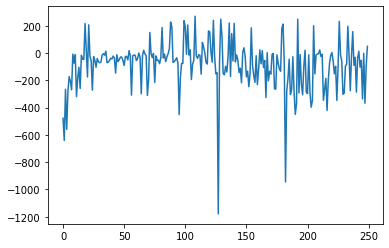

In [12]:
plt.plot(gr.reward_store)

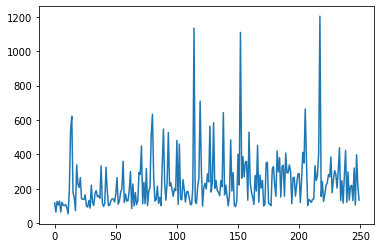

In [13]:
plt.plot(gr.list_steps)

In [ ]:
gr = GameRunner(model = brain,env = env,render=True)
for i in range(50):
    gr.run()

/home/neijunior/.conda/envs/callidus-IAtorch/lib/python3.9/site-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


-37.33734067181358
129
-37.17017393689423
114
214.3252936005867
255
-223.34884149427822
236
-261.07290739364333
263
-59.922277946077564
149
167.447092110995
802
-50.79336296354175
128
-45.33945686132101
438
-20.55793908516418
126
-25.005478272214845
108
-29.140761080588334
126
-7.232276426575837
120
-82.9029345186374
166
-64.19007820924998
217
-2058.4593606799376
533
-53.05573565919002
154
-46.88327141084483
145
-58.34619930291989
242
246.7377613533304
260
-64.27383125774838
181
238.83912763760782
238
-12.101780653680109
102
-71.23349654831084
154
-58.734116998100475
250
-259.12749038073474
269
132.83471271102752
339
-85.2541485200281
266
-36.64442790742511
194
-243.62021193471227
240
16.45457610019828
120
216.64365982979302
623
-36.493432390591536
189
34.62152311064486
160
213.70695295497092
196
-62.65070620340457
269
-94.94128818000084
226
-273.7747904883448
269
-51.450379860169775
116
22.3711635866501
108
-30.519351209980314
492
